In [93]:
import numpy as np
import pandas as pd

# **DATA IMPORT & PREPROCESSING**

In [94]:
# Preprocessing for topic modeling result
def tp_preprocessing(tp, type_check):
    tp_df = tp
    cn = tp_df['cmp']
    
    for i, val in enumerate(cn):
        if '(주)' in val:
            tmp = val.replace('(주)','')
            tp_df.loc[i,'cmp'] = tmp
    
    col_list = list(tp_df.columns)
    col_list[0] = 'company_name'
    for i in range(1, len(tp_df.columns)):
        if type_check == 'adv':
            col_list[i] = 'adv_topic_' + str(col_list[i])
        if type_check == 'dadv':
            col_list[i] = 'dadv_topic_' + str(col_list[i])
    tp_df.columns = col_list

    return tp_df

In [95]:
# Preprocessing for financial variable
def fv_preprocessing(fv):
  fv_df = fv
  afv = fv_df['average_salary']
  tfv = fv_df['total_sale']

  for i, val in enumerate(afv):
    if '만원' in val:
      tmp = int(val[:-2].replace(',',''))
      fv_df.loc[i,'average_salary'] = tmp
    if '회사' in val:
      fv_df.loc[i,'average_salary'] = np.NAN
    if '수집' in val:
      fv_df.loc[i,'average_salary'] = np.NAN


  for i, val in enumerate(tfv):
    if '조원' in val:
      tmp = float(val[:-2].replace(',',''))*1000
      fv_df.loc[i,'total_sale'] = tmp
    if '억원' in val:
      tmp = float(val[:-2].replace(',',''))
      fv_df.loc[i,'total_sale'] = tmp
    if '회사' in val:
      fv_df.loc[i,'total_sale'] = np.NAN


  
  return fv_df

In [96]:
# Preprocessing for turn over rate
def tor_preprocessing(tor):
  tor_df = tor
  tor_val = tor_df['turn_over_rate']

  for i, val in enumerate(tor_val):
    if '정보' in val:
      tor_df.loc[i,'turn_over_rate'] = np.NAN
    elif val == '(9999%)' :
      tor_df.loc[i,'turn_over_rate'] = np.NAN
    elif '(' in val:
      tmp = float(val[1:-1].replace('%',''))*0.01
      tor_df.loc[i,'turn_over_rate'] = tmp

  return tor_df

In [97]:
tp_adv = pd.read_csv('input/topic_modeling_result/bank_adv_topic_modeling.csv')
tp_dadv = pd.read_csv('input/topic_modeling_result/bank_dadv_topic_modeling.csv')

fv = pd.read_csv('input/financial_variable/bank_financial_financial_variable.csv')
tor = pd.read_csv('input/turn_over_rate/bank_financial_business_turn_over_rate.csv')

In [98]:
tp_adv = tp_adv.drop(['Unnamed: 0'], axis=1)
tp_adv = tp_preprocessing(tp_adv,'adv')
tp_dadv = tp_dadv.drop(['Unnamed: 0'], axis=1)
tp_dadv = tp_preprocessing(tp_dadv,'dadv')
fv = fv.drop(['Unnamed: 0'], axis=1)
fv = fv_preprocessing(fv)
tor = tor.drop(['Unnamed: 0'], axis=1)
tor = tor_preprocessing(tor)

In [99]:
df = pd.merge(tp_adv, tp_dadv, on = 'company_name', how = 'inner')
df = pd.merge(df, fv, on = 'company_name', how = 'inner')
df = pd.merge(df, tor, on = 'company_name', how = 'inner')
df = df.dropna()
df['average_salary'] = pd.to_numeric(df['average_salary'])
df['total_sale'] = pd.to_numeric(df['total_sale'])

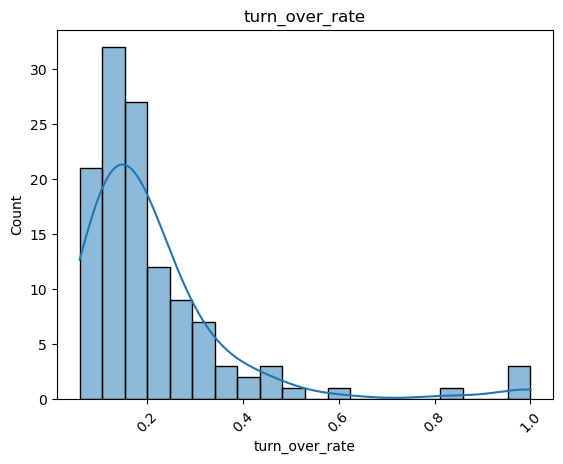

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('turn_over_rate')
plt.xticks(rotation = 45)
sns.histplot(df['turn_over_rate'],kde=True)
plt.show()


In [101]:
for i in df.columns:
    if i != 'company_name' and i != 'turn_over_rate':
        tmp = 'bank '+ i + ' scatter plot'
        plt.title(tmp)
        # log_tor = np.log(df['turn_over_rate'].astype('float'))
        sns.scatterplot(x= df[i], y = df['turn_over_rate'])
        plt.savefig(tmp+'.png')
        plt.cla()
        plt.clf()


<Figure size 640x480 with 0 Axes>

# **MACHINE LEARNING MODEL**

**Linear, Ridge, Lasso**

In [102]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' RMSE: ', np.round(rmse,3))
    return rmse

In [103]:
def get_r2score(model):
    pred = model.predict(X_test)
    score = r2_score(y_test,pred)
    print(model.__class__.__name__, " R2SCORE: ", np.round(score,3))

In [104]:
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [105]:
def get_r2scores(models):
    scores = []
    for model in models:
        score = get_r2score(model)
        scores.append(score)
    return scores

In [106]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

y_target = df['turn_over_rate']
x_data = df.drop(['company_name','turn_over_rate'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_target, test_size = 0.2, random_state = 7)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
print('\n')
get_r2scores(models)


LinearRegression  RMSE:  0.16
Ridge  RMSE:  0.107
Lasso  RMSE:  0.112


LinearRegression  R2SCORE:  -0.63
Ridge  R2SCORE:  0.277
Lasso  R2SCORE:  0.203


[None, None, None]

In [107]:
def get_top_bottom_coef(model, n=4):

    coef = pd.Series(model.coef_, index=x_data.columns)

    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)

    return coef_high, coef_low

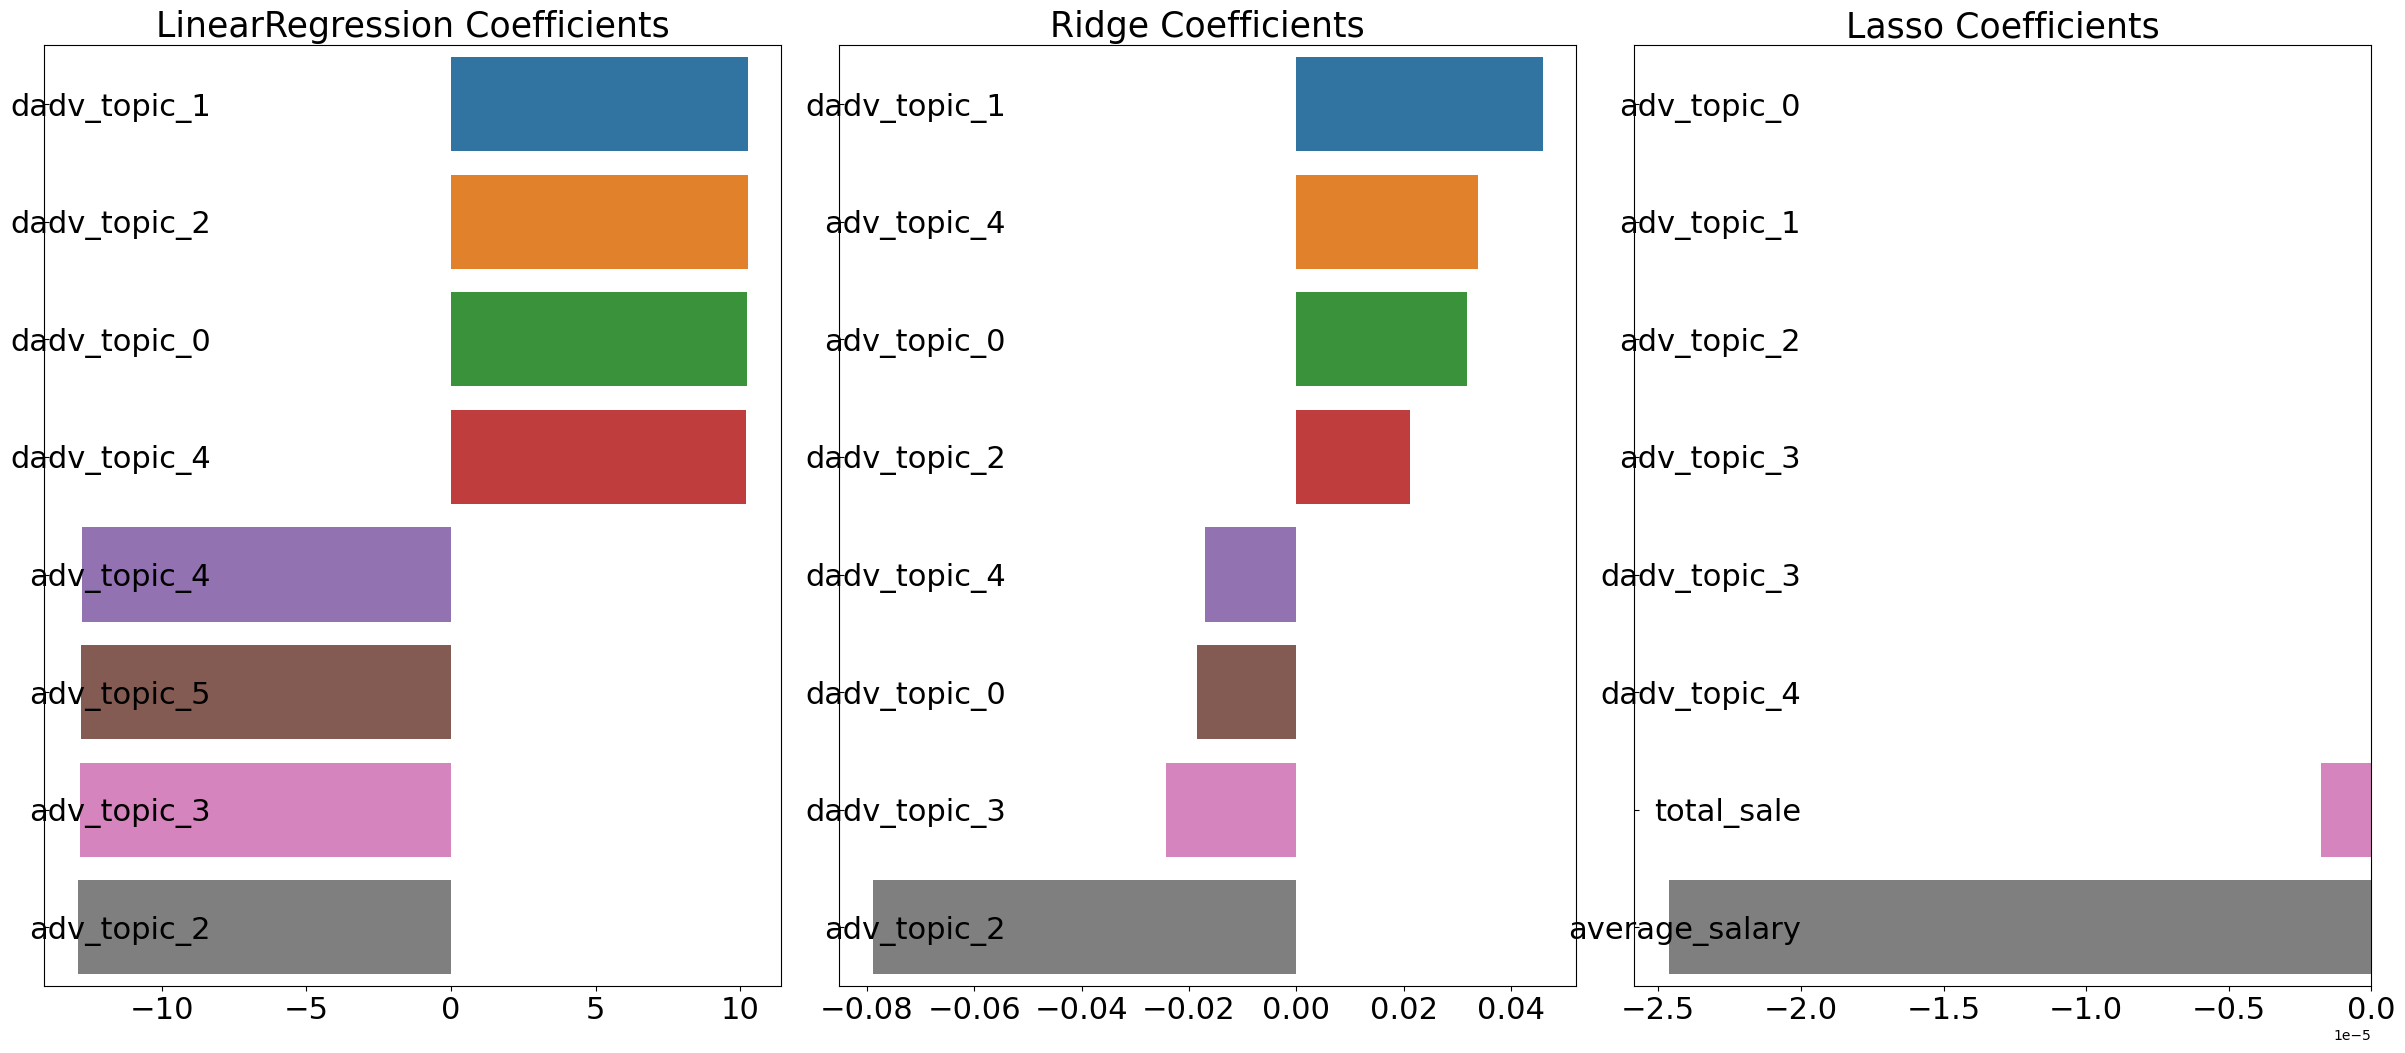

In [108]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize = (24,10), nrows = 1, ncols= 3)
    fig.tight_layout()

    for i_num, model in enumerate(models):

        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in",pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax = axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [109]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:

        rmse_list = np.sqrt(-cross_val_score(model, x_data, y_target,
                                             scoring= 'neg_mean_squared_error', cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE Value List: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('\n{0} CV average RMSE Value List: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE Value List: [0.08  0.118 0.21  0.174 0.193]

Ridge CV average RMSE Value List: 0.155

Lasso CV RMSE Value List: [0.077 0.102 0.208 0.162 0.189]

Lasso CV average RMSE Value List: 0.148


In [110]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(x_data,y_target.astype(float))
    mse = -1 * grid_model.best_score_
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} After 5 CV, best average MSE: {1}, best average RMSE: {2}, best alpha: {3}'.format(model.__class__.__name__,np.round(mse,4),
                                                                           np.round(rmse,4),grid_model.best_params_))
    
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_absolute_error', cv=5)
    grid_model.fit(x_data,y_target.astype(float))
    mae = -1 * grid_model.best_score_
    print('{0} After 5 CV, best average MAE: {1}, best average RMSE: {2}, best alpha: {3}'.format(model.__class__.__name__,np.round(mse,4),

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge After 5 CV, best average RMSE: 0.1574, best alpha: {'alpha': 20}
Lasso After 5 CV, best average RMSE: 0.156, best alpha: {'alpha': 5}


LinearRegression  RMSE:  0.16
Ridge  RMSE:  0.109
Lasso  RMSE:  0.112


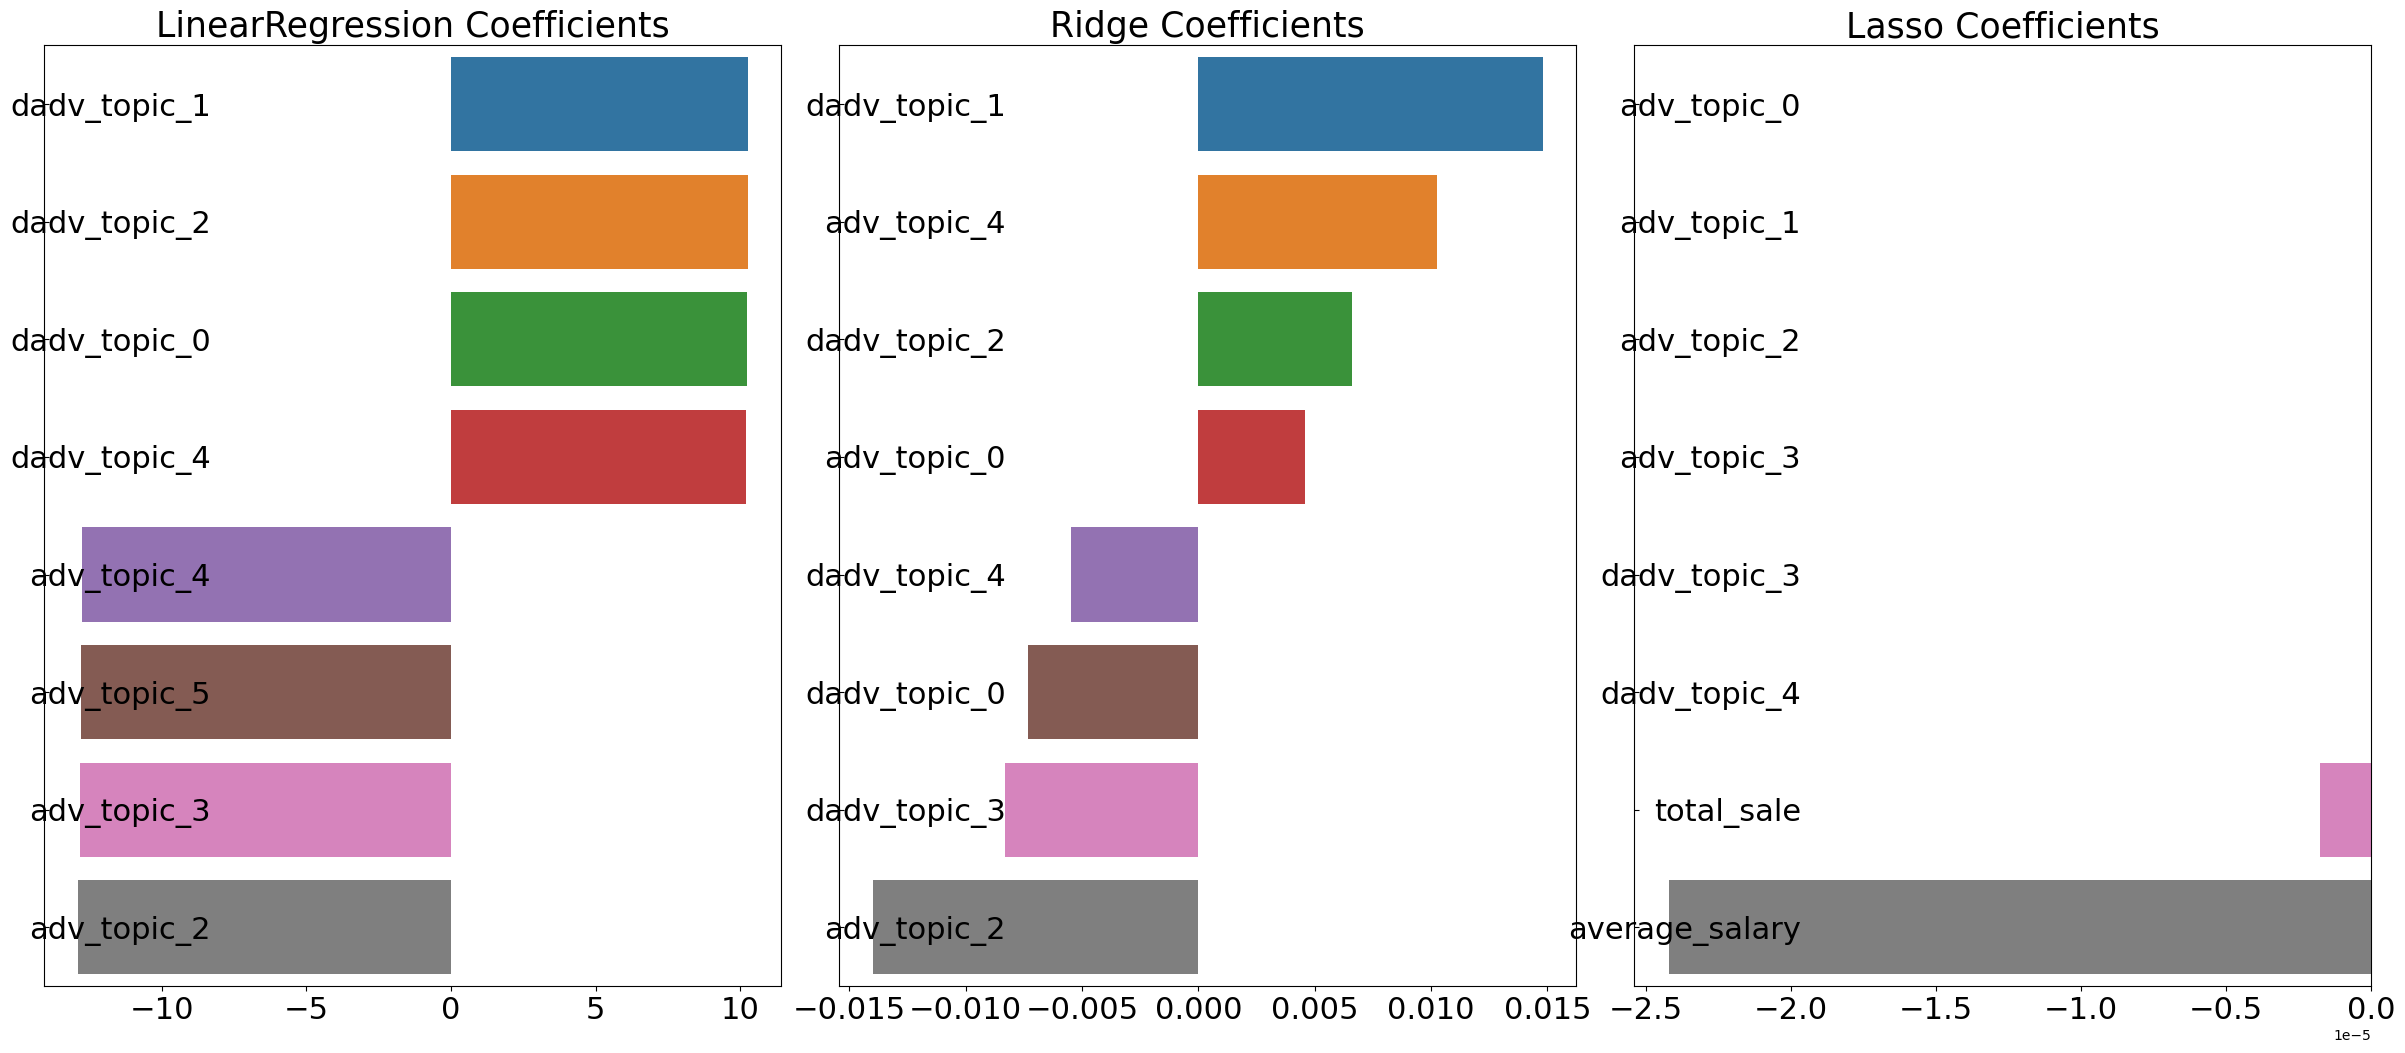

In [111]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=5)
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

visualize_coefficient(models)

In [112]:
from scipy.stats import skew

feature_index = df.dtypes[df.dtypes != 'object'].index

skew_features = df[feature_index].apply(lambda x: skew(x))

skew_feature_top = skew_features[skew_features > 1]
print(skew_feature_top.sort_values(ascending=False))

adv_topic_2     5.373889
total_sale      4.540094
adv_topic_4     3.284244
adv_topic_0     2.995200
adv_topic_1     2.002146
dadv_topic_2    1.908131
dadv_topic_3    1.567450
dadv_topic_1    1.498051
dadv_topic_4    1.469057
dadv_topic_0    1.091960
dtype: float64


In [113]:
for feature in skew_feature_top.index:
    nonzero_indices = df[feature] != 0  # 0이 아닌 값의 인덱스를 찾음
    df.loc[nonzero_indices, feature] = np.log1p(df.loc[nonzero_indices, feature])

In [114]:
y_target = df['turn_over_rate']
x_data = df.drop(['company_name','turn_over_rate'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_target, test_size = 0.2, random_state = 7)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge After 5 CV, best average RMSE: 0.1568, best alpha: {'alpha': 20}
Lasso After 5 CV, best average RMSE: 0.1556, best alpha: {'alpha': 0.005}


LinearRegression  RMSE:  0.121
Ridge  RMSE:  0.108
Lasso  RMSE:  0.11


LinearRegression  R2SCORE:  0.075
Ridge  R2SCORE:  0.258
Lasso  R2SCORE:  0.227


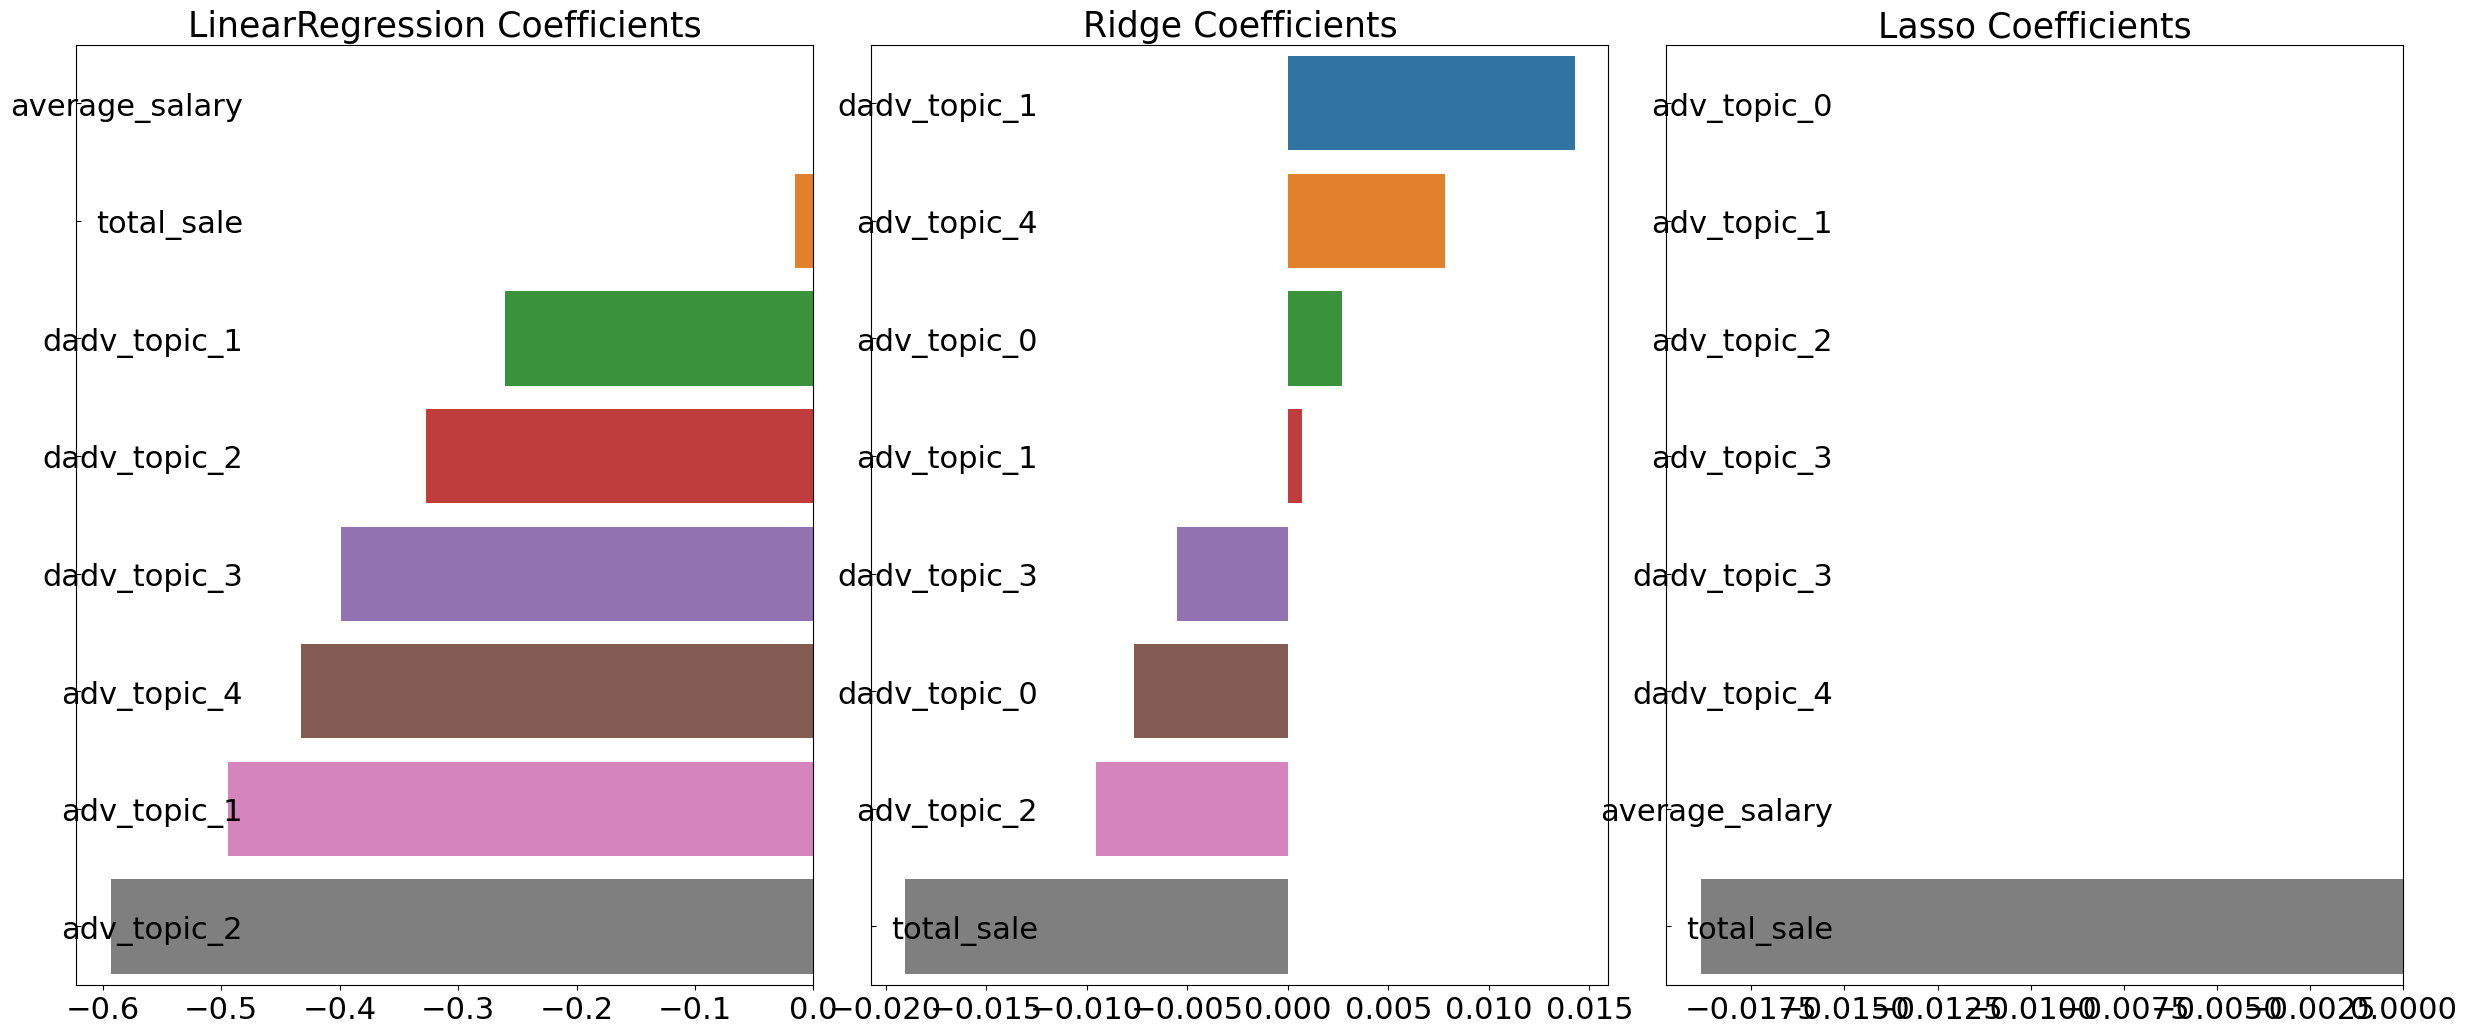

In [115]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
print('\n')
get_r2scores(models)

visualize_coefficient(models)

**Decision Tree with Regression**

In [116]:
from xgboost import XGBRegressor 

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor After 5 CV, best average RMSE: 0.1564, best alpha: {'n_estimators': 1000}


In [117]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate= 0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg,lgbm_params)

LGBMRegressor After 5 CV, best average RMSE: 0.1686, best alpha: {'n_estimators': 1000}


In [131]:
from sklearn.ensemble import GradientBoostingRegressor

gb_params = {'n_estimators': [1000]}
gb_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate= 0.05, subsample=0.6 )
print_best_params(gb_reg,gb_params)


GradientBoostingRegressor After 5 CV, best average RMSE: 0.1702, best alpha: {'n_estimators': 1000}


In [119]:
from sklearn.ensemble import RandomForestRegressor

rf_params = {'n_estimators': [1000]}
rf_reg = RandomForestRegressor(n_estimators=1000)
print_best_params(rf_reg,rf_params)

RandomForestRegressor After 5 CV, best average RMSE: 0.1561, best alpha: {'n_estimators': 1000}


In [120]:
from sklearn.tree import DecisionTreeRegressor

dt_params = {}
dt_reg = DecisionTreeRegressor(max_depth=4)
print_best_params(dt_reg, dt_params)

DecisionTreeRegressor After 5 CV, best average RMSE: 0.2231, best alpha: {}


<Axes: >

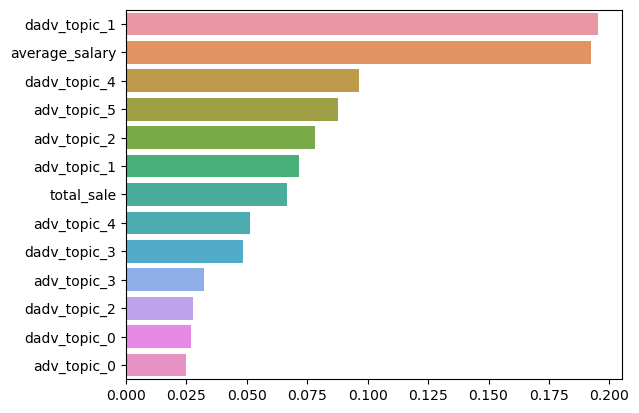

In [121]:
# Feature graph xgb
xgb_reg.fit(x_data, y_target)

feature_series = pd.Series(data = xgb_reg.feature_importances_, index =x_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y= feature_series.index)

<Axes: >

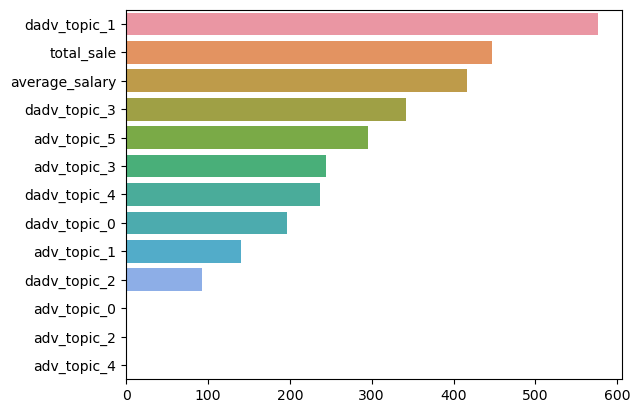

In [122]:
# Feature Graph lgbm
lgbm_reg.fit(x_data, y_target.astype('float'))

feature_series = pd.Series(data = lgbm_reg.feature_importances_, index =x_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y= feature_series.index)


<Axes: >

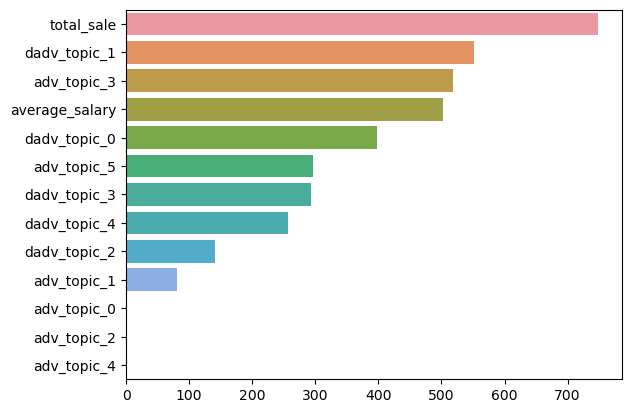

In [123]:
# Feature graph gradient boosting

gb_reg.fit(x_data, y_target.astype('float'))

feature_series = pd.Series(data = gb_reg.feature_importances_, index =x_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y= feature_series.index)

<Axes: >

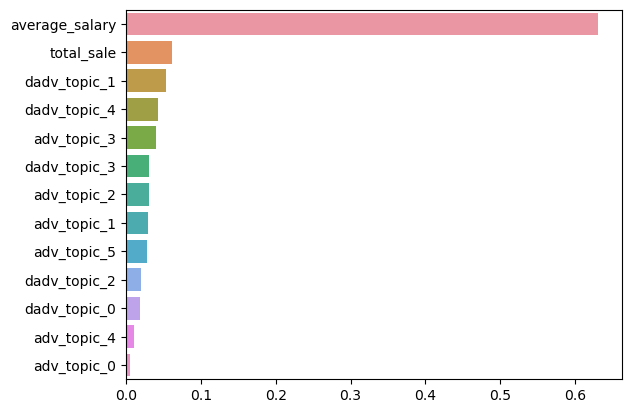

In [124]:
# Feature graph randomforest

rf_reg.fit(x_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index =x_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y= feature_series.index)


<Axes: >

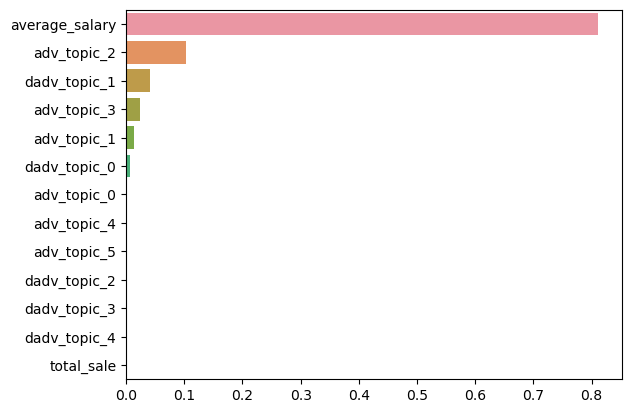

In [125]:
# Feature Graph DecisionTree
dt_reg.fit(x_data, y_target.astype('float'))

feature_series = pd.Series(data = dt_reg.feature_importances_, index =x_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y= feature_series.index)

Combination of Regression Model

In [126]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} model\'s RMSE: {1}'.format(key, rmse))

# single model
ridge_reg = Ridge(alpha = 20)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha = 0.05)
lasso_reg.fit(X_train,y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.5 * ridge_pred + 0.5 * lasso_pred

preds = {'final combined': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

get_rmse_pred(preds)

final combined model's RMSE: 0.1100811550694346
Ridge model's RMSE: 0.10799994845963293
Lasso model's RMSE: 0.11287415954076192


In [127]:
# xgb boost and random forest

xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
rf_reg = RandomForestRegressor(n_estimators=1000)

xgb_reg.fit(X_train,y_train)
rf_reg.fit(X_train,y_train)

xgb_pred = xgb_reg.predict(X_test)
rf_pred = rf_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * rf_pred
preds = {'final combined': pred,
         'XGBoost': xgb_pred,
         'RandomForest': rf_pred}

get_rmse_pred(preds)


final combined model's RMSE: 0.12125004749457977
XGBoost model's RMSE: 0.124050862680418
RandomForest model's RMSE: 0.12376573183236146


Stacking Ensemble

In [128]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):

    kf = KFold(n_splits=n_folds, shuffle=False)

    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,' model start ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):

        print('\t fold set: ', folder_counter, ' start')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr, y_tr)

        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    return train_fold_pred, test_pred_mean

In [129]:
X_train_n = X_train.values
X_test_n = X_test.values

y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model start 
	 fold set:  0  start
	 fold set:  1  start
	 fold set:  2  start
	 fold set:  3  start
	 fold set:  4  start
Lasso  model start 
	 fold set:  0  start
	 fold set:  1  start
	 fold set:  2  start
	 fold set:  3  start
	 fold set:  4  start
XGBRegressor  model start 
	 fold set:  0  start
	 fold set:  1  start
	 fold set:  2  start
	 fold set:  3  start
	 fold set:  4  start
RandomForestRegressor  model start 
	 fold set:  0  start
	 fold set:  1  start
	 fold set:  2  start
	 fold set:  3  start
	 fold set:  4  start


In [130]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, rf_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, rf_test),axis=1)

meta_model_lasso = Lasso(alpha = 0.005)

meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('Stacking regression model\'s final RMSE: ',rmse)

Stacking regression model's final RMSE:  0.10785724440633092
